In [1]:
import scanpy as sc
import logging
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx

In [11]:
base_dir = '/home/xlv0877/proj_home/dl/perturb-seq/data/processed'

In [12]:
meta = []
for file in os.listdir(base_dir):
    if file.endswith('h5ad'):
        print(file)
        m = sc.read(os.path.join(base_dir, file), backed='r').obs
        m['dataset'] = file.split('.h5ad')[0]
        m.index = m.index.astype(str) + m['dataset'].astype(str)
        meta.append(m)
meta = pd.concat(meta, axis=0)

ReplogleWeissman2025_Jurkat.h5ad
TianKampmann2021_CRISPRa.h5ad
ReplogleWeissman2025_HepG2.h5ad
TianKampmann2019_iPSC.h5ad
TianKampmann2021_CRISPRi.h5ad
ReplogleWeissman2022_rpe1.h5ad
DatlingerBock2021.h5ad
ReplogleWeissman2022_K562_gwps.h5ad
ShifrutMarson2018.h5ad
TianKampmann2019_day7neuron.h5ad
FrangiehIzar2021_RNA.h5ad
ReplogleWeissman2022_K562_essential.h5ad
NormanWeissman2019_filtered.h5ad


In [13]:
# remove multiple perturbations
all_perturbations = meta.perturbation.str.split('_', expand=True)
col = all_perturbations.iloc[:, 1]
mask = (
    col.isna() |
    col.str.match(r'^\d+$|^pDS|^pBA')
)
meta_single = meta[mask].copy()

In [14]:
print(f'{meta.shape[0]-meta_single.shape[0]} multiple perturbations detected and removed')
meta_single['perturbation'] = all_perturbations[mask].iloc[:,0].str.replace(r'g[0-9]$', '', regex=True)
meta_single['perturbation'] = meta_single['perturbation'].str.replace(r'^ES.sg[0-9]*.', '', regex=True)

0 multiple perturbations detected and removed


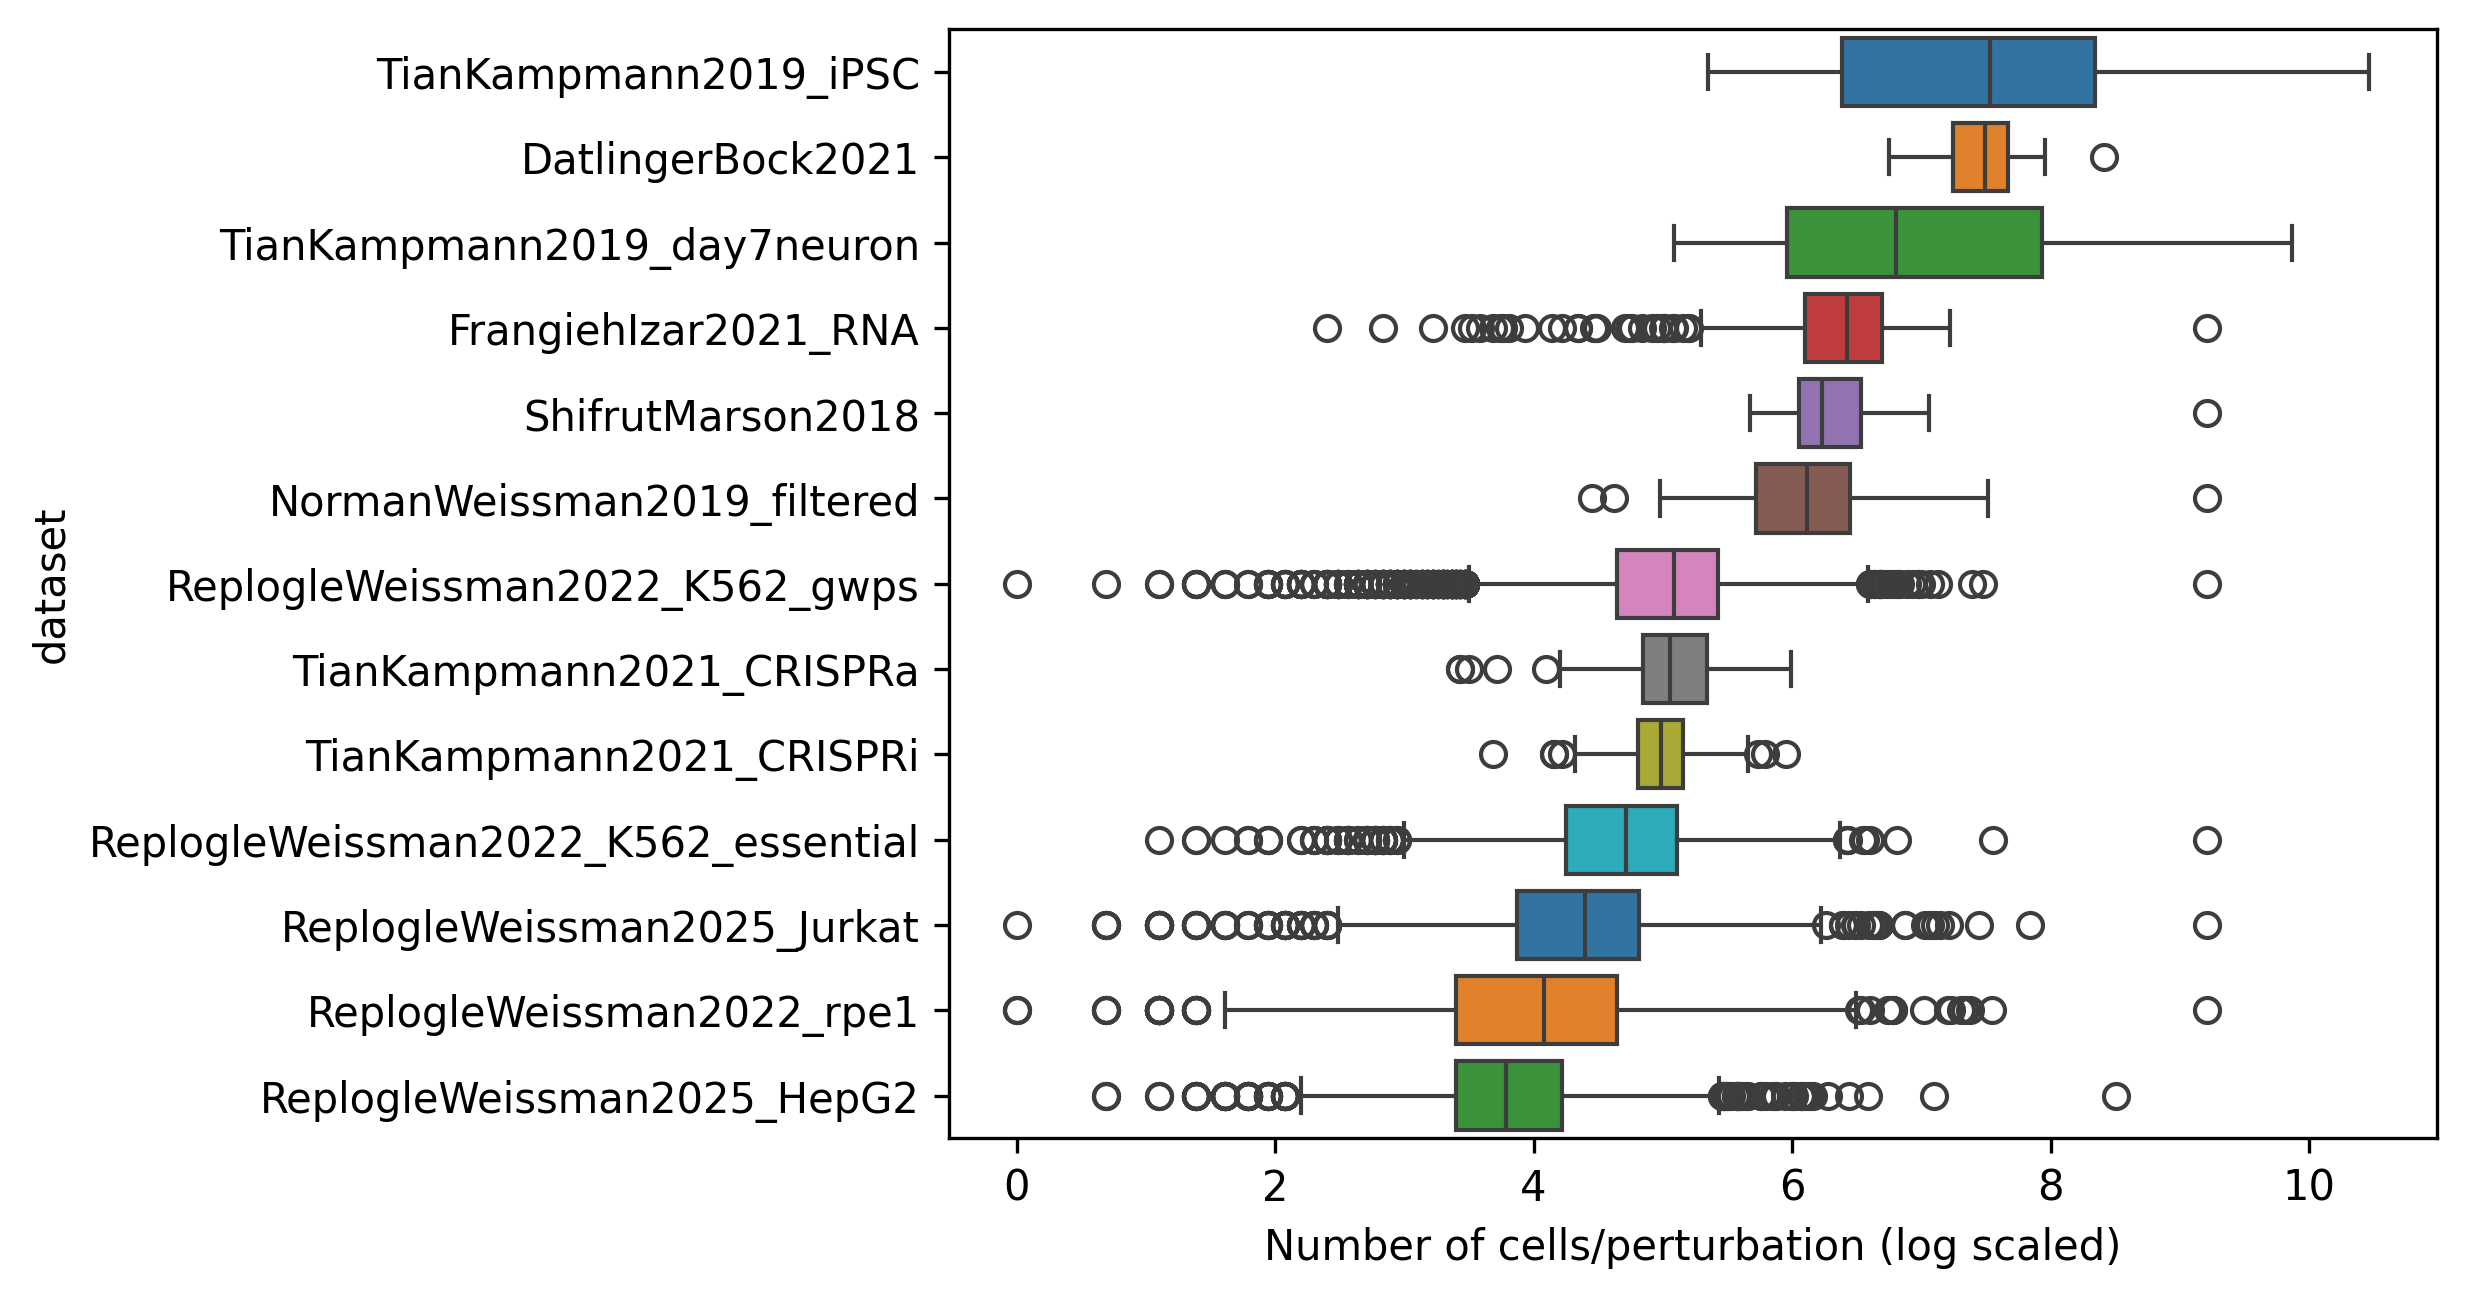

In [15]:
# check number of cells/perturbation
df = meta_single.groupby(['dataset', 'perturbation']).size().reset_index()
df.columns = ['dataset', 'perturbation', 'n_cells']
df = df[df.n_cells > 0]
df['n_cells_log'] = np.log(df.n_cells)
no_ctrl = df[df.perturbation!='control'].copy()
fig = plt.figure(dpi=300)
df.dataset = pd.Categorical(df.dataset, categories=df.groupby('dataset')['n_cells_log'].median().sort_values(ascending=False).index)
ax = sns.boxplot(df, x='n_cells_log', y='dataset', palette='tab10', hue='dataset')
plt.xlabel('Number of cells/perturbation (log scaled)')
plt.title('')
plt.show()

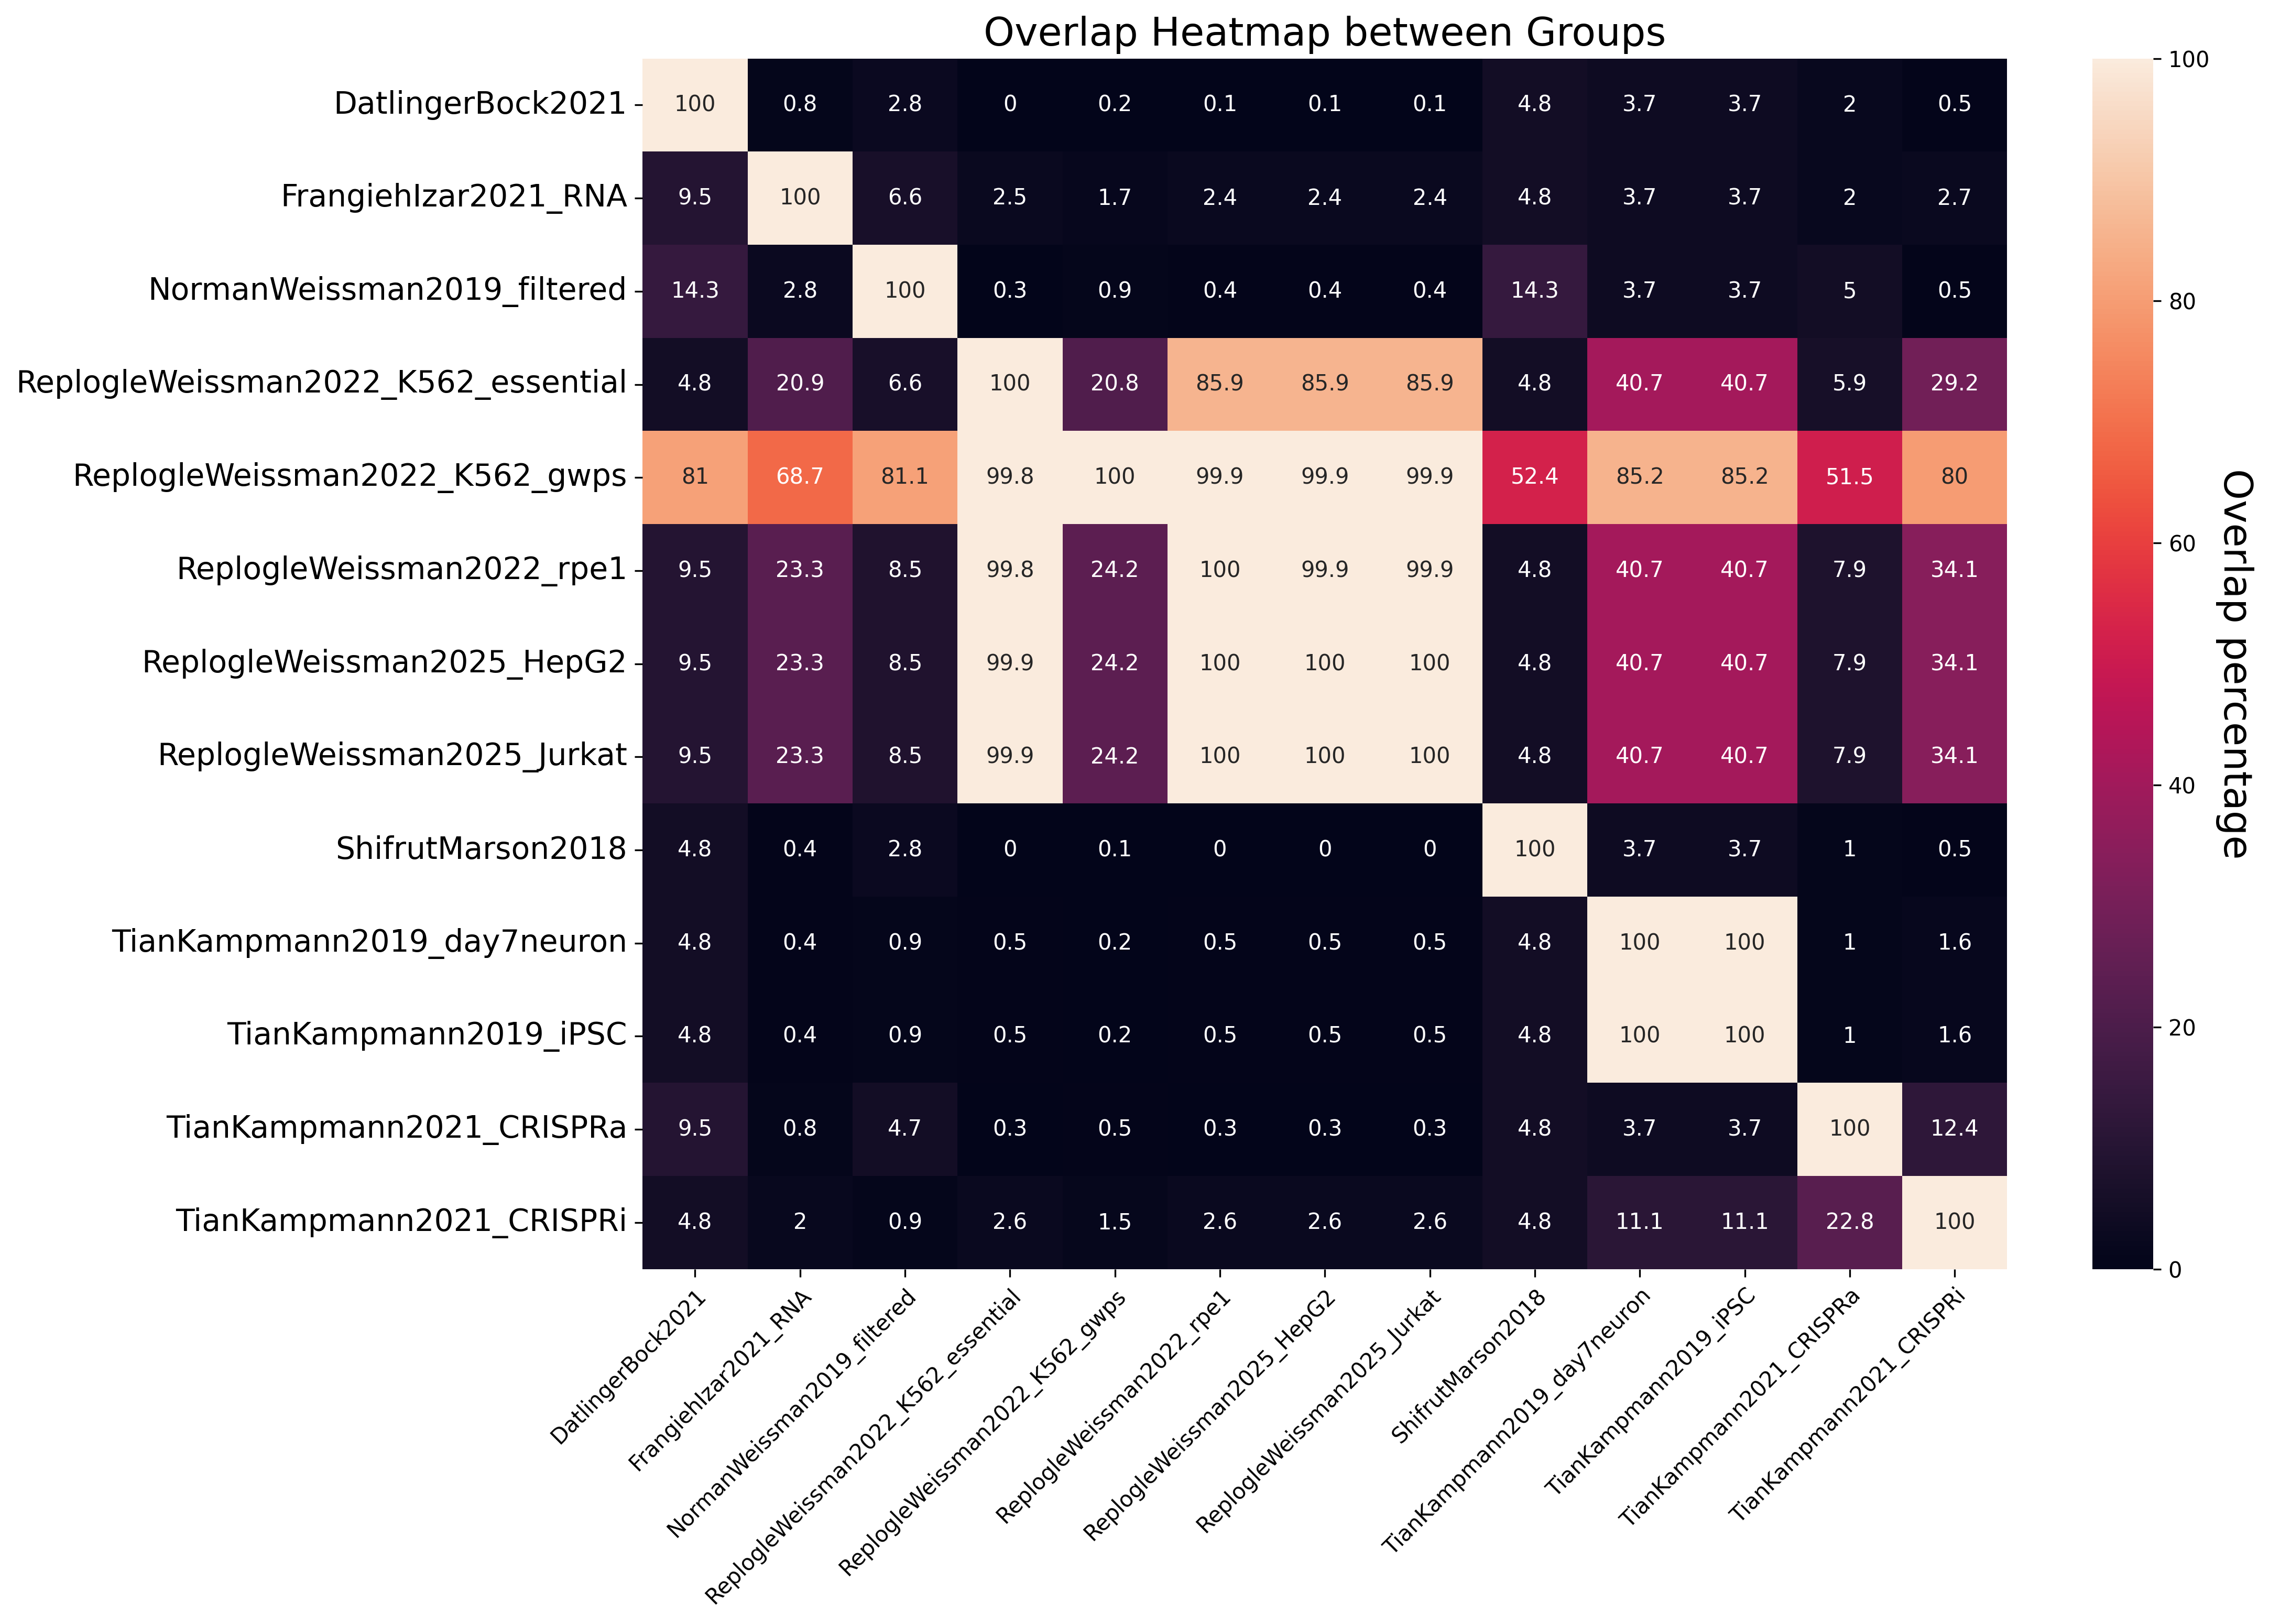

In [21]:
# check overlap in perturbations

df = meta_single
unique_values = df.groupby('dataset')['perturbation'].unique()
groups = unique_values.keys()
overlap_matrix = np.zeros((len(groups), len(groups)))

for i, group1 in enumerate(groups):
    for j, group2 in enumerate(groups):
        both = len(set(unique_values[group1]).intersection(unique_values[group2]))
        total = len(set(unique_values[group1]).union(set(unique_values[group2])))
        n_g1 = len(set(unique_values[group1]))
        n_g2 = len(set(unique_values[group2]))
        perc = np.round(both/n_g1*100, 1)
        overlap_matrix[i, j] = perc

# Create a heatmap
fig = plt.figure(dpi=300, figsize=(14,10))
ax = sns.heatmap(overlap_matrix.T, xticklabels=groups, yticklabels=groups, fmt='g', annot=True)
cbar = ax.collections[0].colorbar  # Get the colorbar object
cbar.set_label('Overlap percentage', rotation=270, labelpad=20, fontsize=18)
plt.title("Overlap Heatmap between Groups", fontsize=18)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
#plt.xticks([])
plt.yticks(fontsize=14)
plt.show()

In [17]:
meta_single.shape

(3162196, 65)

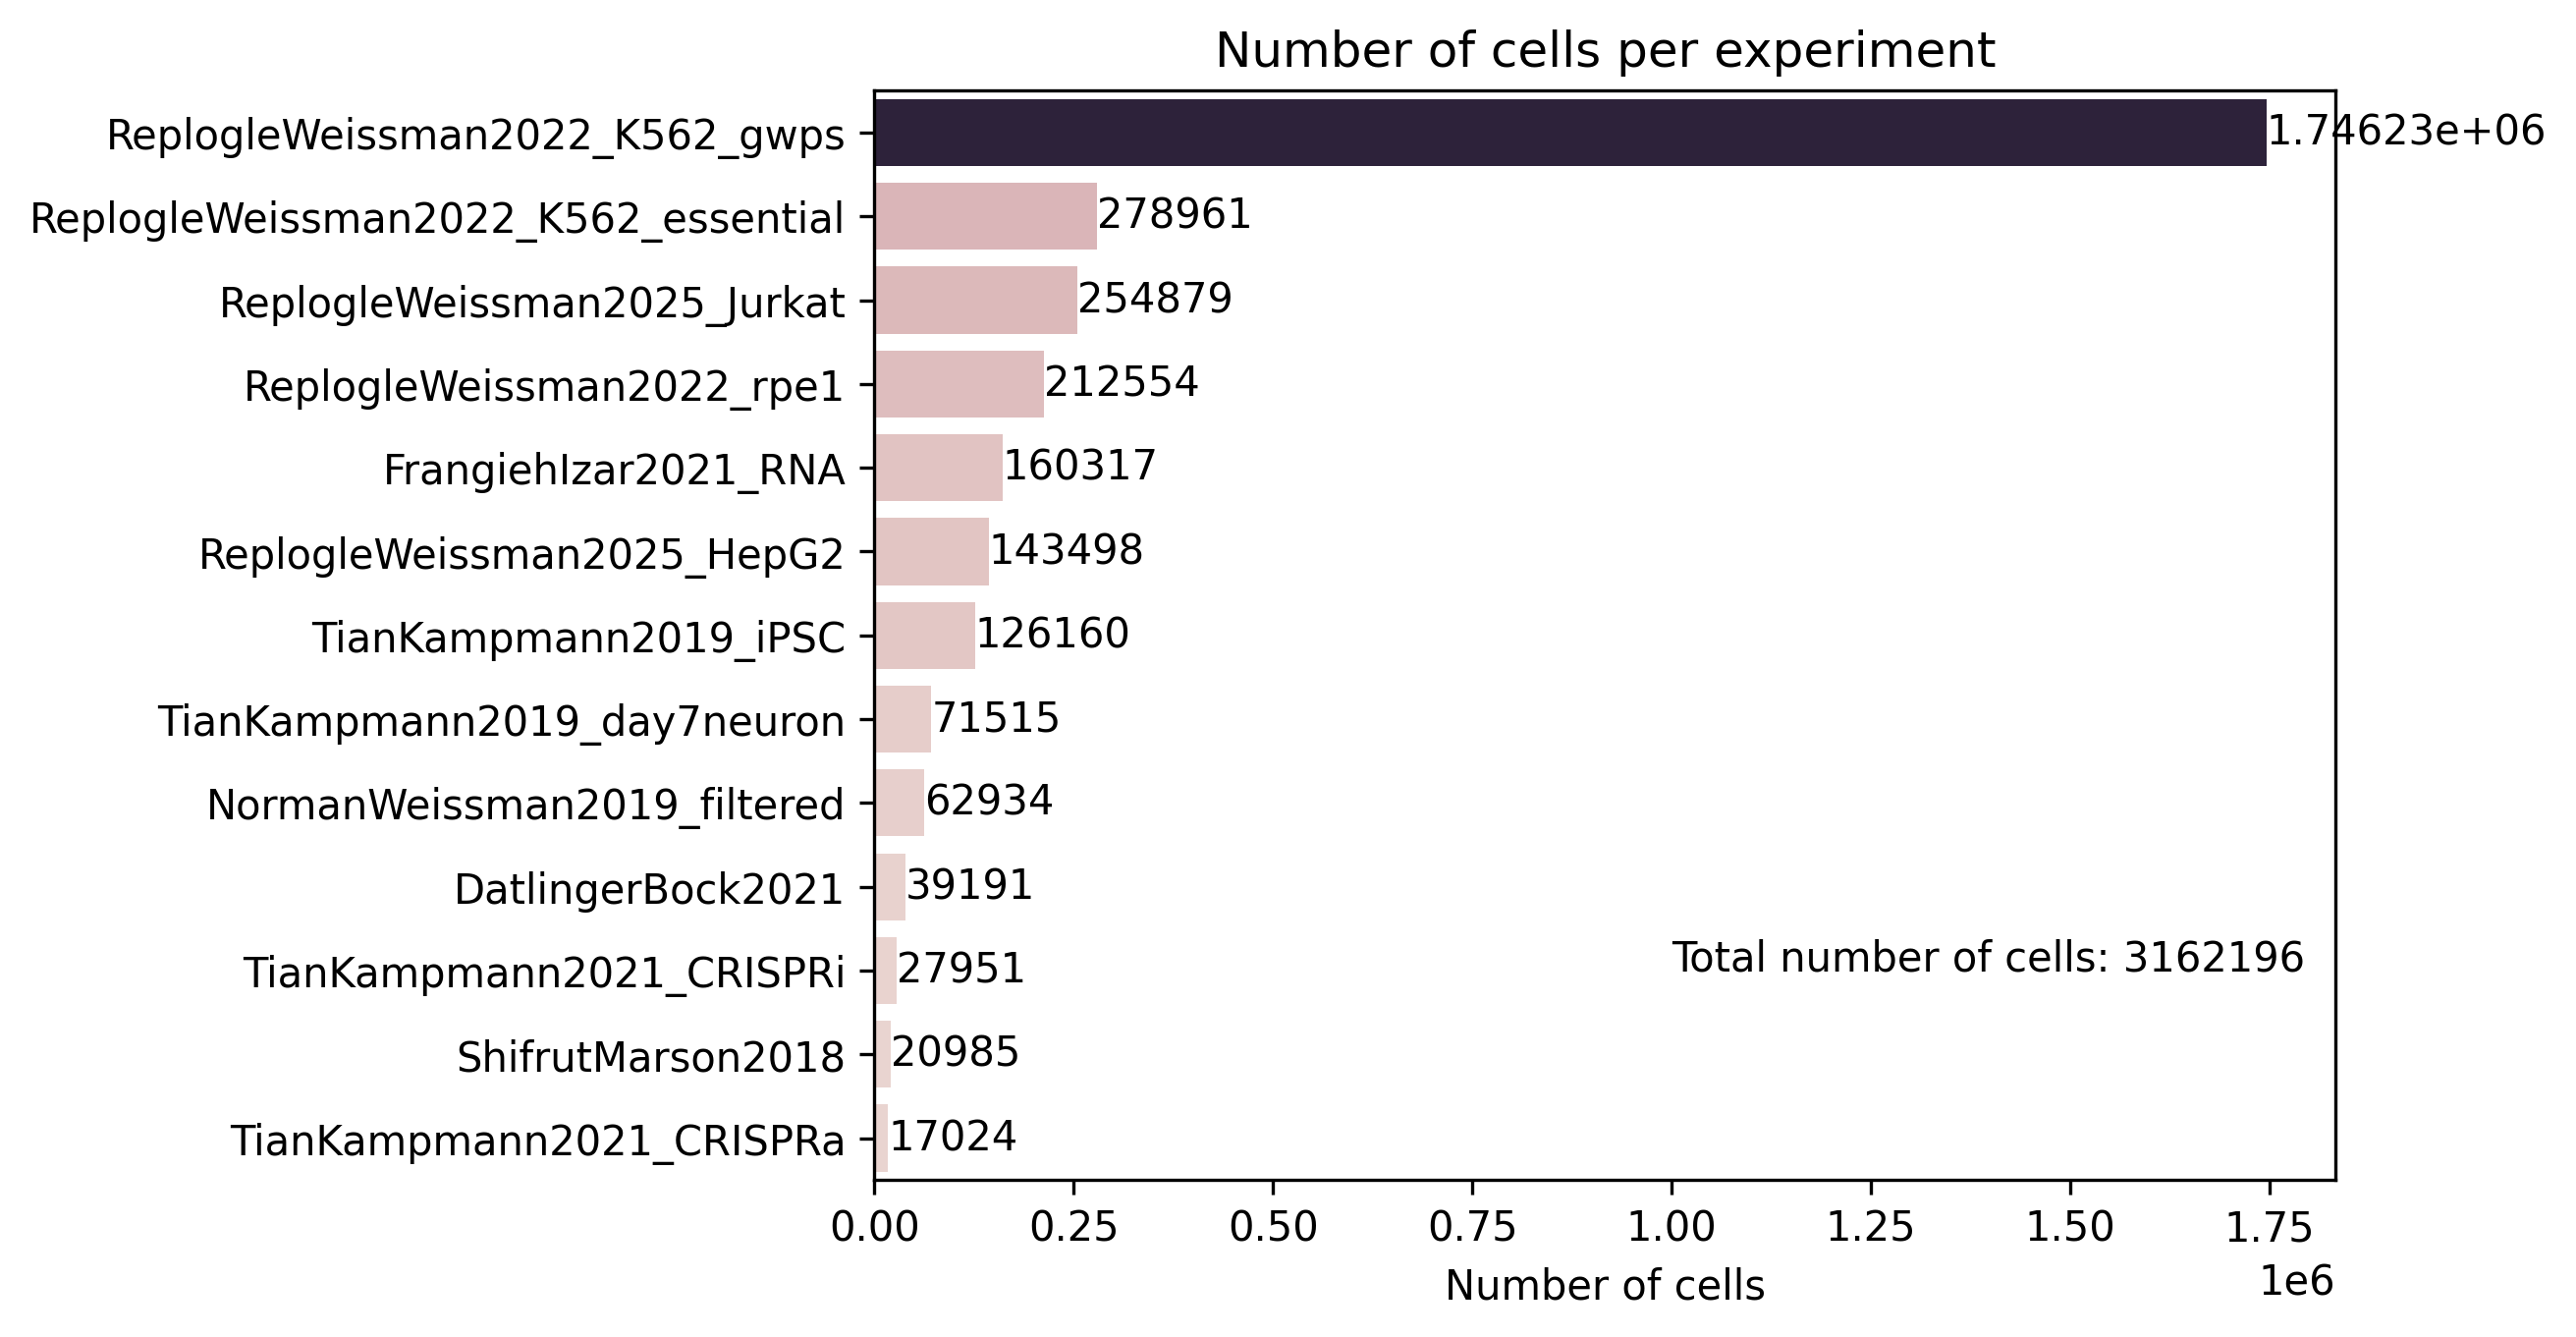

In [18]:
df = pd.DataFrame(meta_single.dataset.value_counts()).reset_index()
fig = plt.figure(dpi=300)
ax = sns.barplot(df, x='count', y='dataset', orient='y', hue='count', order=df.dataset.values, legend=False)
for c in ax.containers:
    ax.bar_label(c, fontsize=10)
plt.title('Number of cells per experiment')
plt.xlabel('Number of cells')
plt.text(s=f'Total number of cells: {meta_single.shape[0]}', x=1e6, y=10)
plt.ylabel('')
plt.show()

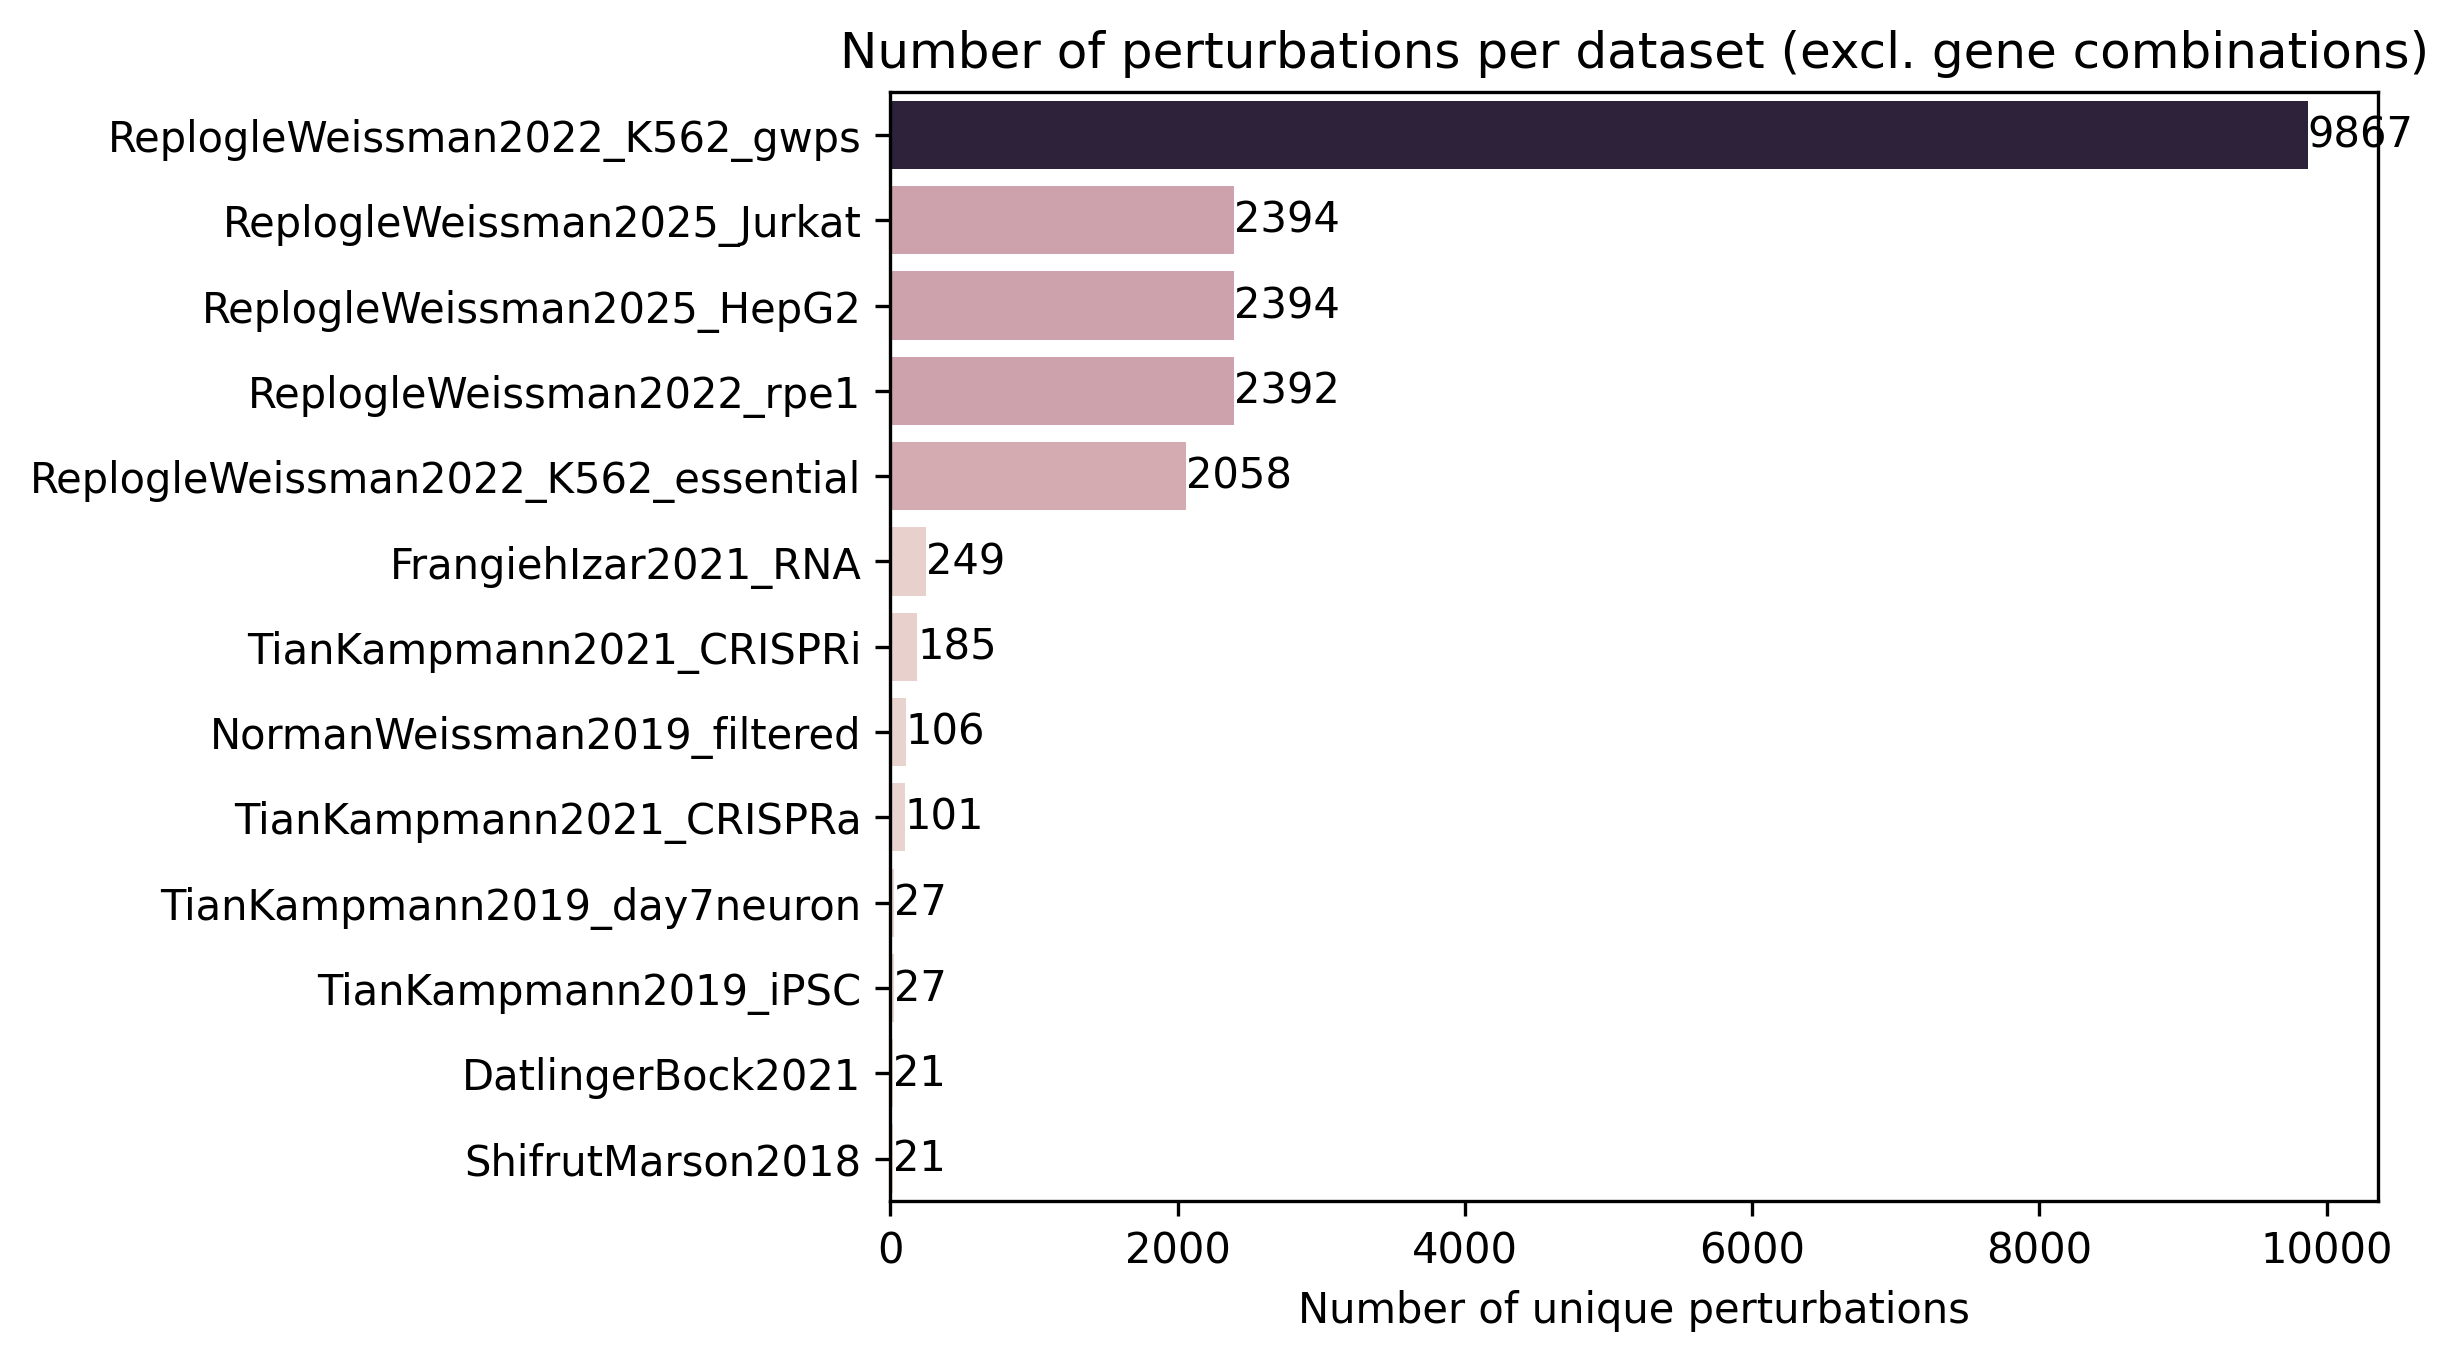

In [19]:
df = meta_single
df = df.groupby('dataset').perturbation.nunique().reset_index().sort_values('perturbation', ascending=False)
fig = plt.figure(dpi=300)
ax = sns.barplot(df, x='perturbation', y='dataset', orient='y', hue='perturbation', order=df.dataset.values, legend=False)
for c in ax.containers:
    ax.bar_label(c, fontsize=10)
plt.title('Number of perturbations per dataset (excl. gene combinations)')
plt.xlabel('Number of unique perturbations')
plt.ylabel('')
plt.show()

In [30]:
# Build a perturbation pool out of the consensus of genome-wide replogle scans
df = meta_single[meta_single.dataset.str.startswith('Replogle')]
perturbation_pool = set.intersection(*df.groupby('dataset', observed=True)['perturbation'].apply(lambda x: set(x.unique())))
print(f'Pool dim: {len(perturbation_pool)} gene-perturbations')

Pool dim: 2049 gene-perturbations


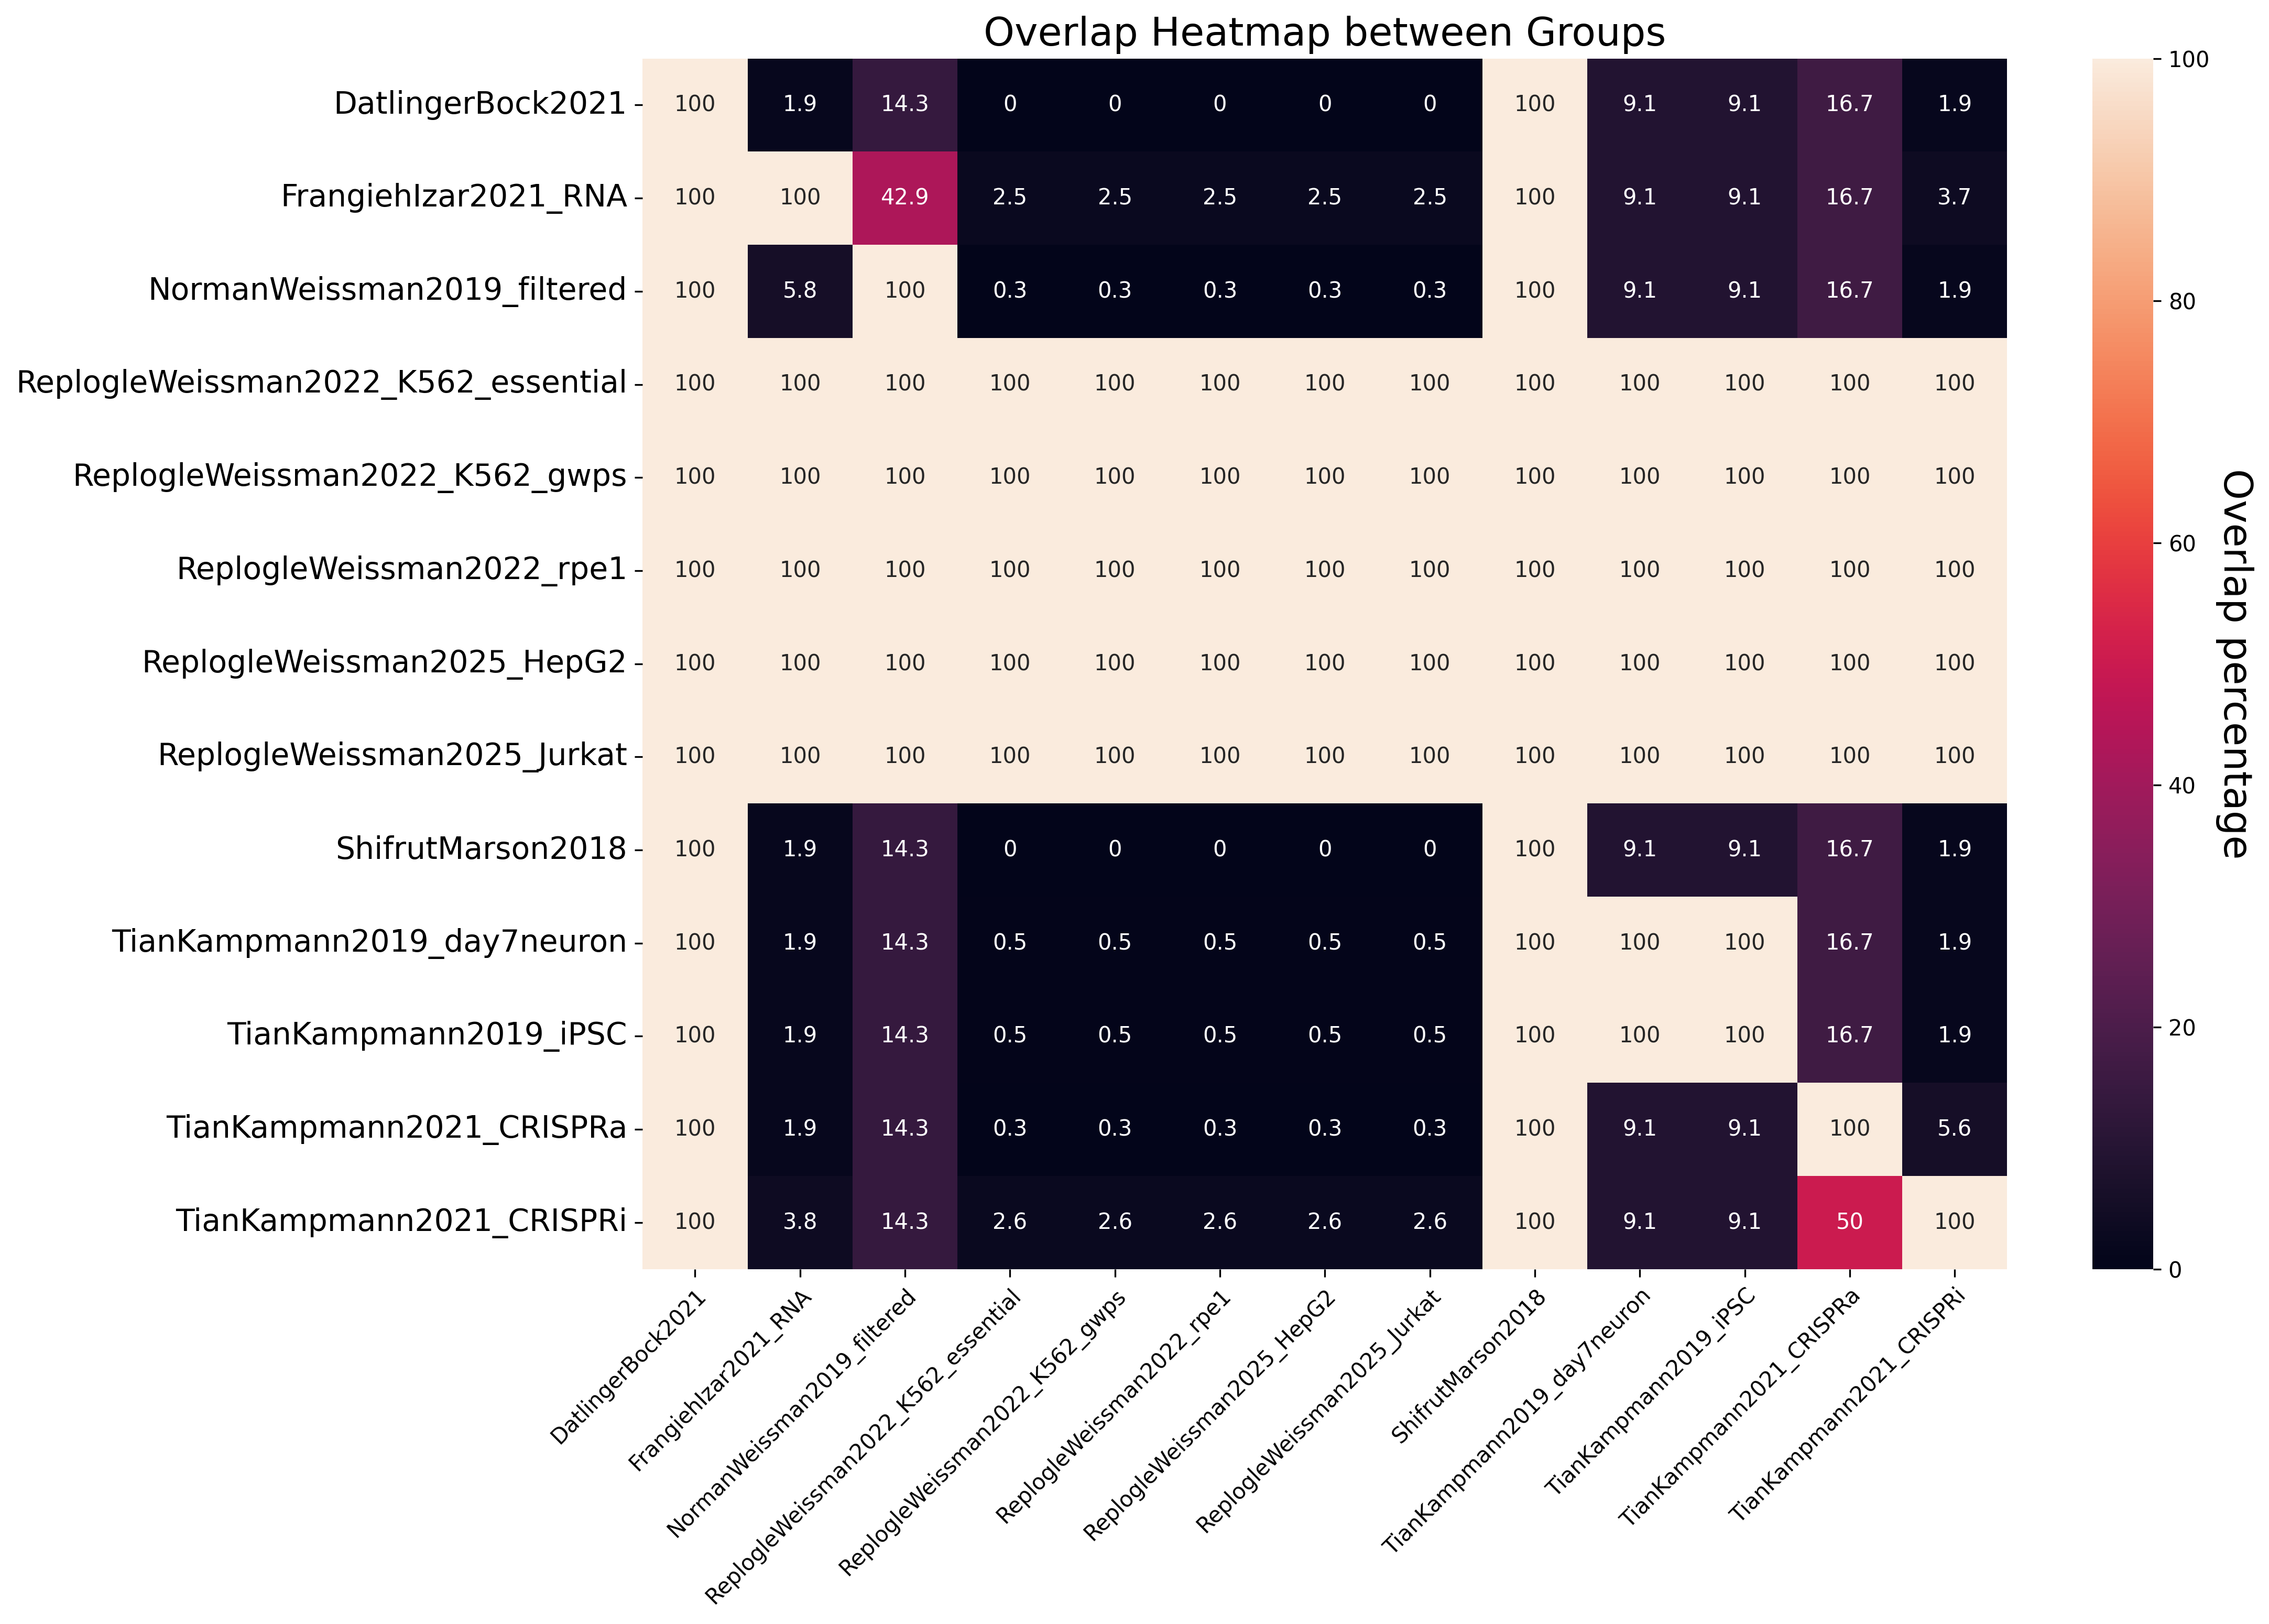

In [33]:
df = meta_single[meta_single.perturbation.isin(perturbation_pool)]
# check overlap in perturbations
unique_values = df.groupby('dataset')['perturbation'].unique()
groups = unique_values.keys()
overlap_matrix = np.zeros((len(groups), len(groups)))

for i, group1 in enumerate(groups):
    for j, group2 in enumerate(groups):
        both = len(set(unique_values[group1]).intersection(unique_values[group2]))
        total = len(set(unique_values[group1]).union(set(unique_values[group2])))
        n_g1 = len(set(unique_values[group1]))
        n_g2 = len(set(unique_values[group2]))
        perc = np.round(both/n_g1*100, 1)
        overlap_matrix[i, j] = perc

# Create a heatmap
fig = plt.figure(dpi=300, figsize=(14,10))
ax = sns.heatmap(overlap_matrix.T, xticklabels=groups, yticklabels=groups, fmt='g', annot=True)
cbar = ax.collections[0].colorbar  # Get the colorbar object
cbar.set_label('Overlap percentage', rotation=270, labelpad=20, fontsize=18)
plt.title("Overlap Heatmap between Groups", fontsize=18)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
#plt.xticks([])
plt.yticks(fontsize=14)
plt.show()

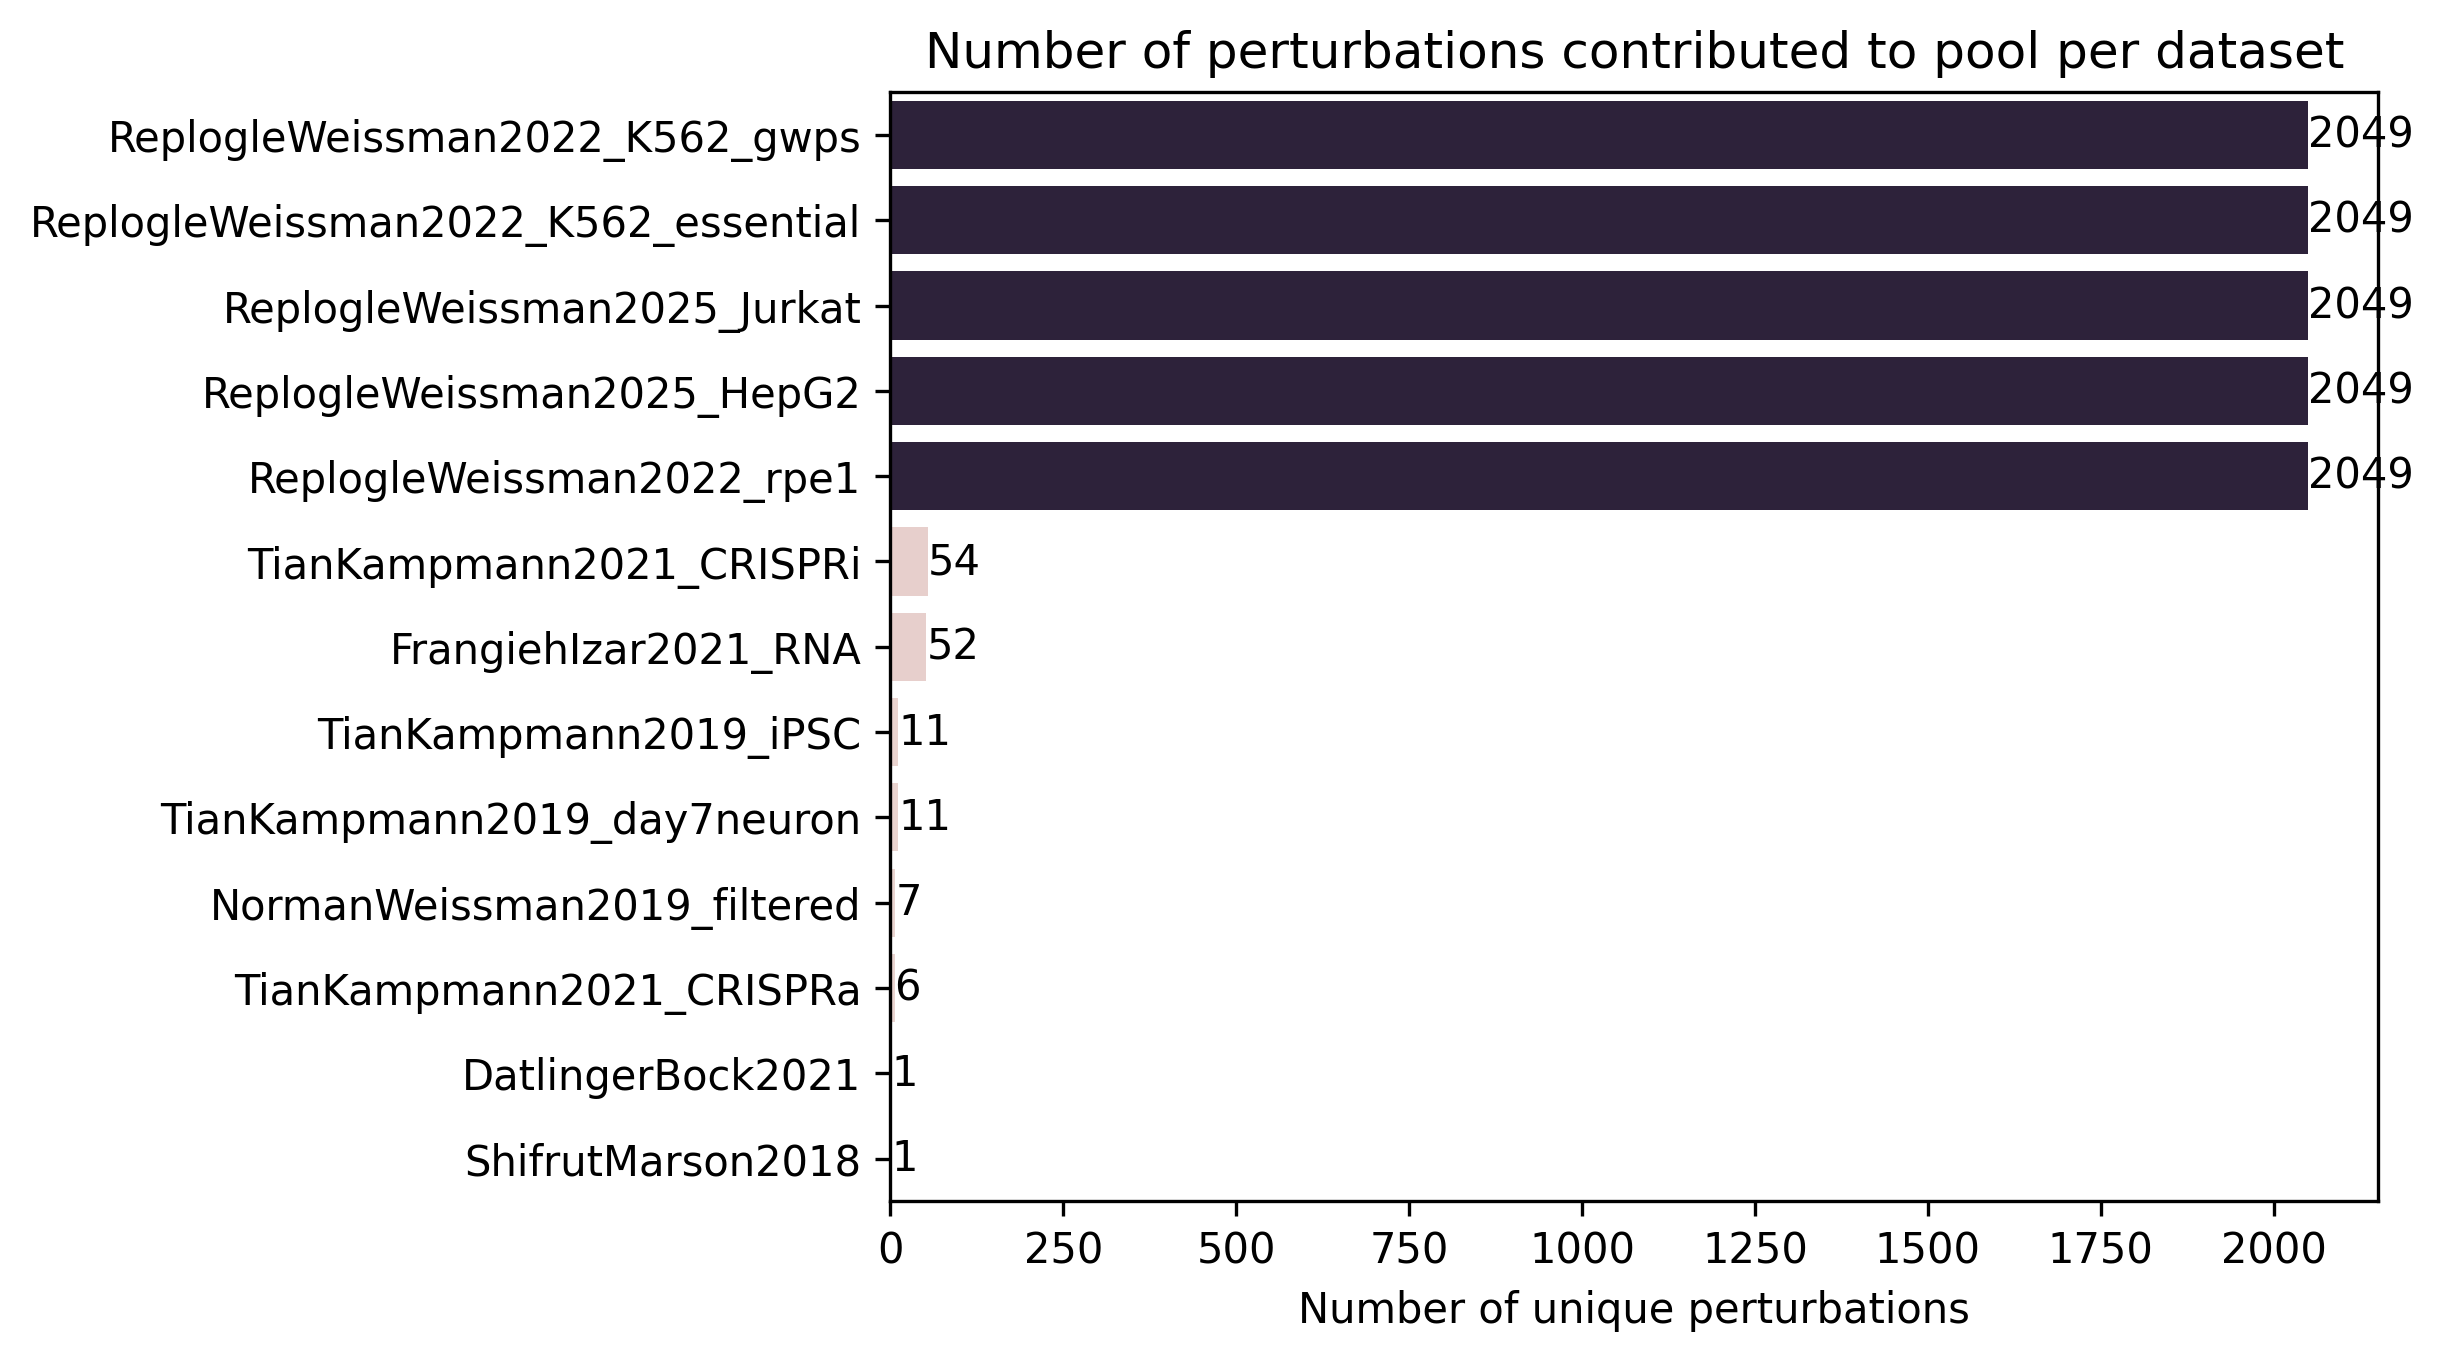

In [35]:
df = meta_single[meta_single.perturbation.isin(perturbation_pool)]
df = df.groupby('dataset').perturbation.nunique().reset_index().sort_values('perturbation', ascending=False)
fig = plt.figure(dpi=300)
ax = sns.barplot(df, x='perturbation', y='dataset', orient='y', hue='perturbation', order=df.dataset.values, legend=False)
for c in ax.containers:
    ax.bar_label(c, fontsize=10)
plt.title('Number of perturbations contributed to pool per dataset')
plt.xlabel('Number of unique perturbations')
plt.ylabel('')
plt.show()

In [38]:
adata = sc.read('/home/xlv0877/proj_home/dl/perturb-seq/data/raw/ReplogleWeissman2025_Jurkat.h5ad')

In [39]:
adata.var_names.str.lower().str.startswith('ens').all()

True

In [42]:
adata.var.head()

,gene_name,chr,start,end,class,strand,length,in_matrix,mean,std,cv,fano
gene_id,,,,,,,,,,,,
ENSG00000237491,LINC01409,chr1,778747,810065,gene_version10,+,31318,True,0.155002,0.417462,2.693264,1.124335
ENSG00000228794,LINC01128,chr1,825138,868202,gene_version9,+,43064,True,0.287165,0.572515,1.993682,1.141413
ENSG00000188976,NOC2L,chr1,944203,959309,gene_version11,-,15106,True,0.939766,1.160949,1.235359,1.434190
ENSG00000188290,HES4,chr1,998962,1000172,gene_version10,-,1210,True,2.612689,3.524809,1.349112,4.755362
ENSG00000187608,ISG15,chr1,1001138,1014540,gene_version10,+,13402,True,3.091917,2.869021,0.927910,2.662194


In [46]:
gsh = list(adata.var.columns.intersection(set(['gene_name'])).values)[0]

In [48]:
adata.var.reset_index(names='ensembl_id', inplace=True)

In [49]:
adata.var.set_index(gsh, inplace=True)

In [54]:
adata.var_names.nunique() != adata.shape[0]

True

In [59]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000)

In [65]:
adata.var['hm_var'] = (2 * adata.var.means * adata.var.variances_norm) / (adata.var.means + adata.var.variances_norm)

In [72]:
idx = adata.var.reset_index().groupby(gsh, observed=True).hm_var.idxmax().values

In [73]:
adata[:,idx]

View of AnnData object with n_obs × n_vars = 262956 × 8881
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI'
    var: 'ensembl_id', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'hm_var'
    uns: 'hvg'